In [ ]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

provider = "google_genai" # "google_genai" / "openai"

if provider == "google_genai":
    llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
elif provider == "openai":
    llm = init_chat_model("gpt-5-mini", model_provider="openai")

In [2]:
ai_message = llm.invoke(
    "Who's your maker? Also, tell me the name of an interesting historic moment from a random century."
)

print(ai_message.content)

I am a large language model, trained by Google.

As for an interesting historic moment from a random century, let's go with the **18th century**:

**The Storming of the Bastille** on July 14, 1789. This event, where an angry mob attacked the medieval fortress and prison in Paris, symbolized the beginning of the French Revolution. It was a pivotal moment that dramatically escalated the revolutionary fervor, signaling the collapse of royal authority and inspiring people across France and beyond to challenge absolute monarchies. It's interesting because it wasn't just a military victory, but a powerful symbolic act that ignited a complete societal transformation.


In [94]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_openai import OpenAIEmbeddings

if provider == "google_genai":
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
elif provider == "openai":
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [95]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [96]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [97]:
print(docs[0].page_content[:600])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several 


In [98]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents")

Split blog post into 63 sub-documents


In [77]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['fc180a44-ea03-45aa-9898-37c3c1ffa459', '0aa1465a-709f-4456-bc64-078acbb8ff3c', '6f49ea50-1a14-4207-86e6-8b03fe61a3a5']


In [99]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {
        "context": "(context goes here)",
        "question": "(question goes here)",
    }
).to_messages()

print(example_messages[0].content)

c:\Projects\gen-ai-rag-bot\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [79]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [80]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [81]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

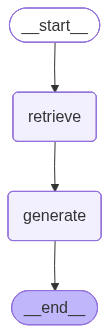

In [82]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [83]:
# result = graph.invoke({"question": "What is Task Decomposition?"})
result = graph.invoke({"question": "What is LSH (Locality-Sensitive Hashing)?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='20e6a423-8675-489c-857c-290f4c8ec143', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 12583}, page_content='LSH (Locality-Sensitive Hashing): It introduces a hashing function such that similar input items are mapped to the same buckets with high probability, where the number of buckets is much smaller than the number of inputs.\nANNOY (Approximate Nearest Neighbors Oh Yeah): The core data structure are random projection trees, a set of binary trees where each non-leaf node represents a hyperplane splitting the input space into half and each leaf stores one data point. Trees are built independently and at random, so to some extent, it mimics a hashing function. ANNOY search happens in all the trees to iteratively search through the half that is closest to the query and then aggregates the results. The idea is quite related to KD tree but a lot more scalable.'), Document(id='e13f1079-075a-4c98-91b7-b1f679a475df', metadata

In [101]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[62].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 42106,
 'section': 'end'}

In [102]:
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [103]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query."
    ]

In [104]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"]
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join([doc.page_content for doc in state["context"]])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

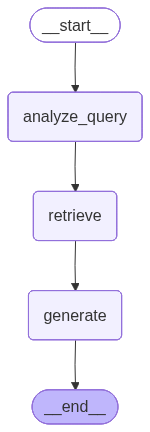

In [105]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [106]:
# result = graph.invoke({"question": "What is LSH (Locality-Sensitive Hashing)?"})
result = graph.invoke({"question": "What does the end of the post say about Task Decomposition?"})

# print(f"Context: {result['context']}\n\n")
# print(f"Answer: {result['answer']}")

result

{'question': 'What does the end of the post say about Task Decomposition?',
 'query': {'section': 'end', 'query': 'Task Decomposition'},
 'context': [Document(id='577687f0-4f16-4783-bae3-07b96113ad15', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 38621, 'section': 'end'}, page_content='are imported by that file, and so on.\\nFollow a language and framework appropriate best practice file naming convention.\\nMake sure that files contain all imports, types etc. The code should be fully functional. Make sure that code in different files are compatible with each other.\\nBefore you finish, double check that all parts of the architecture is present in the files.\\n"'),
  Document(id='1016c082-8bda-4600-a366-f0827f1e8036', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 34990, 'section': 'end'}, page_content='Conversatin samples:\n[\n  {\n    "role": "system",'),
  Document(id='4801ac28-dcee-4341-8d4c-3e